# Определение уязвимых групп населения

## Итоговый проект первого года обучения Skillfactory Data Science Pro

### Часть 2. Моделирование

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import shapiro
from sklearn import cluster, metrics
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 2.1. Очистка и разведочный анализ данных

##### 2.1.1. Описание датасета

In [2]:
df = pd.read_csv(
    'C://Users//Apost//OneDrive//Рабочий стол//social_russia_data//russia_regions_2020.csv', index_col='region')
df.head(3)

,per capita,formal wage,child mortality,disabled 18_60,alco (2018),drug (2018),grp,living area,bad conditions,no funds,...,felonies,misdemeanors,killed,grievous harm,children %,orphanage,adopted %,pension,retired %,living wage
region,,,,,,,,,,,,,,,,,,,,,
Алтайский край,23864.0,30072.0,0.485583,5.093525,88.1,17.4,291156.9,18.0,0.3,0.8642,...,1529,8887,411,647,21.153070,983,59.0,16128.19,26.8,10904.0
Амурская область,35499.0,52430.0,0.534827,5.766846,113.3,24.4,571362.1,17.3,1.3,1.0731,...,560,4967,223,255,22.619247,676,65.0,17998.70,22.4,14331.0
Архангельская область без Ненецкого АО,34852.0,52779.0,0.325623,4.674270,64.7,9.2,514200.4,16.9,1.4,1.2998,...,823,4569,166,288,20.708809,785,60.0,21753.88,26.4,14507.0


In [3]:
df.isnull().sum()

per capita                        0
formal wage                       0
child mortality                   0
disabled 18_60                    0
alco (2018)                       0
drug (2018)                       0
grp                               0
living area                       0
bad conditions                    0
no funds                          0
morbidity (2016)                  0
congenital malformation (2016)    0
psychosis (2016)                  0
teenage pregnancy (2016)          0
birth rate                        0
population                        0
poverty                           0
the poor: children                0
the poor: retired                 0
the poor: employable              0
regional production               0
retail                            0
income                            0
subsidies                         0
welfare                           0
registered crimes                 0
felonies                          0
misdemeanors                

In [4]:
for column in df.columns:
    n_zeros = (df[column] == 0).sum()
    if n_zeros > 0:
        print('Колонка:', column, '   число нулей:', n_zeros)

Колонка: drug (2018)    число нулей: 1
Колонка: bad conditions    число нулей: 2
Колонка: no funds    число нулей: 24
Колонка: teenage pregnancy (2016)    число нулей: 32
Колонка: orphanage    число нулей: 2


##### 2.1.2. Выбор признаков для проведения кластеризации

В качестве критериев группировки регионов по уровню благосостояния выберем следующие показатели, часть из которых после анализа и отбора определят признаковое пространство для кластерного анализа:

In [5]:
cols = ['per capita', 'formal wage', 'grp', 'living area', 'poverty', 
         'regional production', 'retail', 'income', 'subsidies', 'living wage']
model_df = df[cols].copy()
model_df.head(3)

,per capita,formal wage,grp,living area,poverty,regional production,retail,income,subsidies,living wage
region,,,,,,,,,,
Алтайский край,23864.0,30072.0,291156.9,18.0,17.5,367883.929218,153605,24442.874394,32067.902020,10904.0
Амурская область,35499.0,52430.0,571362.1,17.3,15.2,512093.588458,245233,65276.814100,43050.621924,14331.0
Архангельская область без Ненецкого АО,34852.0,52779.0,514200.4,16.9,12.3,607920.547370,250033,48483.000199,38856.664512,14507.0


In [6]:
model_df.describe()

,per capita,formal wage,grp,living area,poverty,regional production,retail,income,subsidies,living wage
count,85.000000,85.000000,8.500000e+01,85.000000,85.000000,8.500000e+01,85.000000,85.000000,85.000000,85.000000
mean,33020.517647,45361.082353,6.676350e+05,17.154118,13.874118,1.140388e+06,199342.423529,47485.670592,46990.414914,12856.247059
std,14912.478645,19827.022626,8.135611e+05,2.286167,5.046006,1.776882e+06,56438.817000,45311.289344,68553.968623,3144.740673
min,16877.000000,29083.000000,1.421997e+05,13.600000,4.800000,1.687176e+04,50713.000000,8737.699442,10021.505932,9834.000000
25%,24864.000000,33139.000000,3.428112e+05,15.800000,10.400000,4.155462e+05,164879.000000,26872.932758,21756.520310,10930.000000
50%,28596.000000,37820.000000,4.607202e+05,16.900000,13.300000,7.073048e+05,197028.000000,33128.431896,28985.395339,11760.000000
75%,33149.000000,48286.000000,5.829507e+05,18.100000,15.600000,1.153898e+06,232860.000000,43789.164998,43161.012387,12943.000000
max,89928.000000,120641.000000,5.206287e+06,27.800000,31.700000,1.192245e+07,408674.000000,270615.683220,583593.839079,24711.000000


##### 2.1.3. Рейтинги регионов по избранным показателям

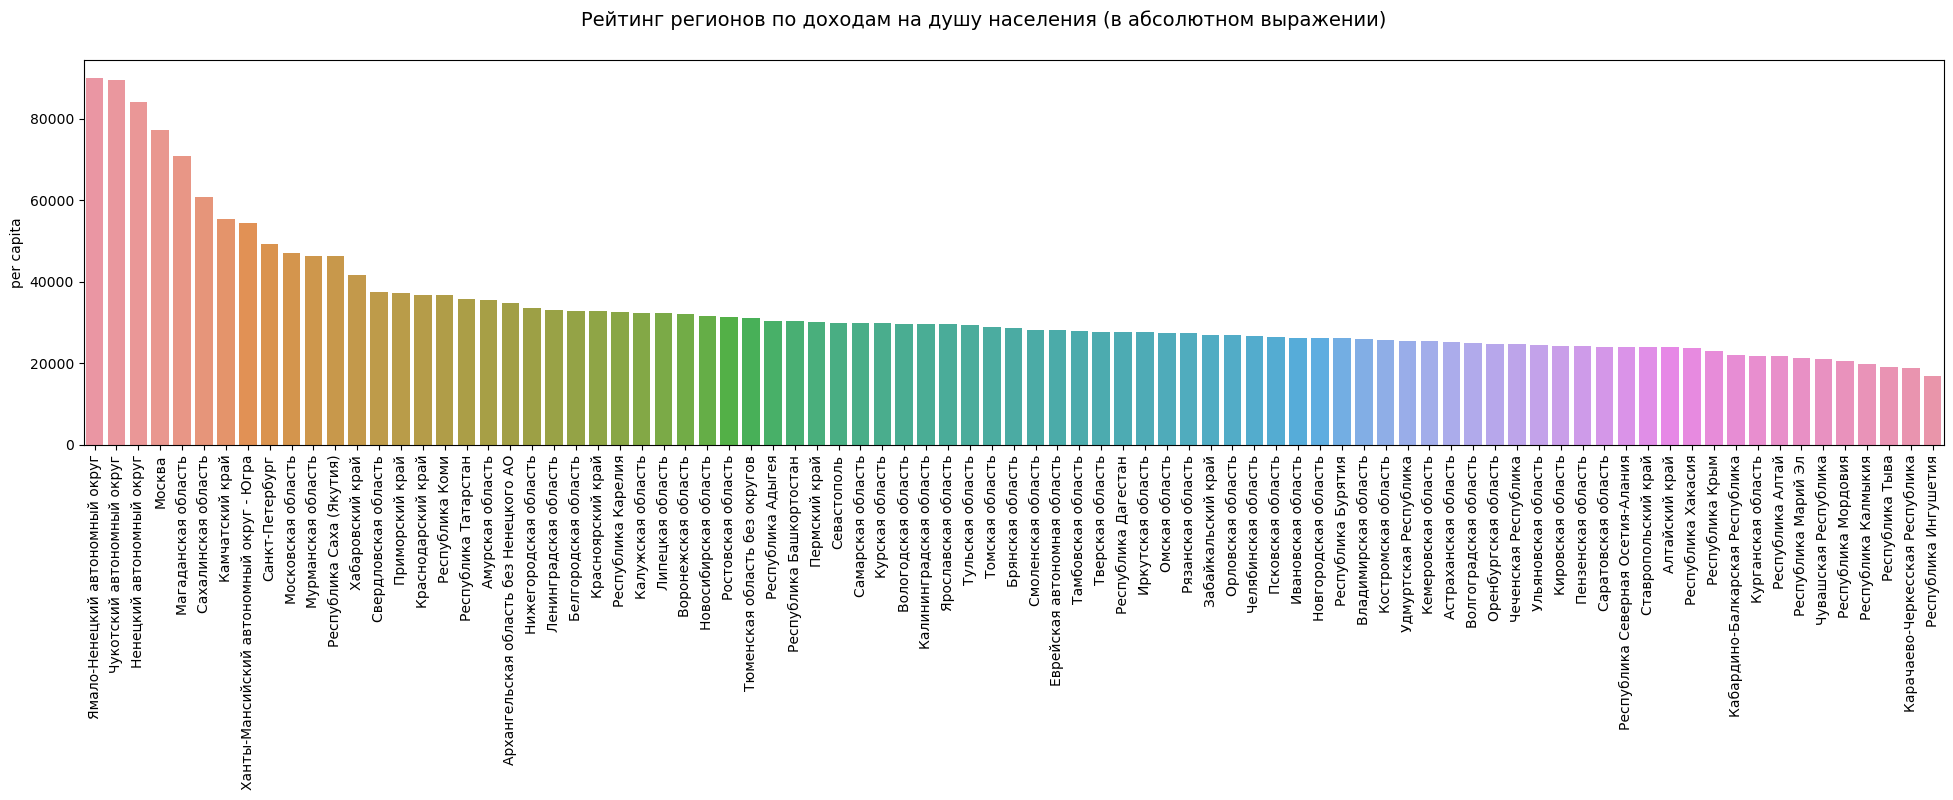

In [7]:
plot_df = model_df.sort_values(by='per capita', ascending=False)
fig = plt.figure(figsize=(24,5))
sns.barplot(data=plot_df, x=plot_df.index, y='per capita')
fig.suptitle(
    'Рейтинг регионов по доходам на душу населения (в абсолютном выражении)',
    fontsize=14);
plt.xlabel('')
plt.xticks(rotation = 90);

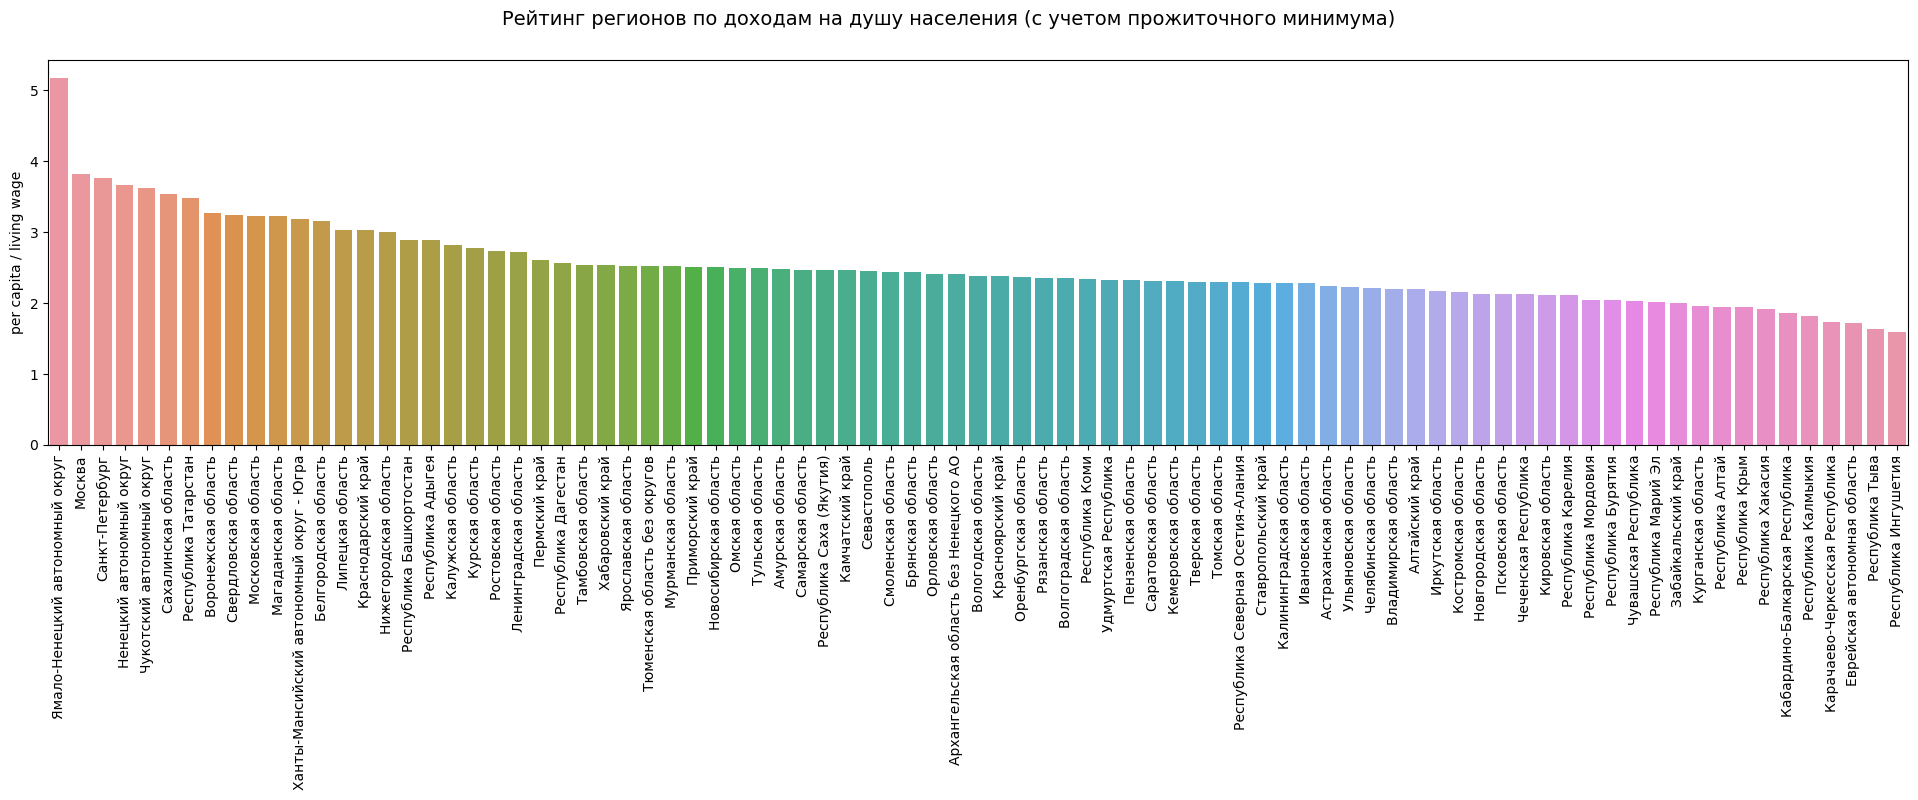

In [8]:
plot_df['per capita norm'] = plot_df['per capita'] / plot_df['living wage']
plot_df.sort_values(by='per capita norm', ascending=False, inplace=True)
fig = plt.figure(figsize=(24,5))
sns.barplot(data=plot_df, x=plot_df.index, y='per capita norm')
fig.suptitle(
    'Рейтинг регионов по доходам на душу населения (с учетом прожиточного минимума)',
    fontsize=14);
plt.xlabel('')
plt.ylabel('per capita / living wage')
plt.xticks(rotation = 90);

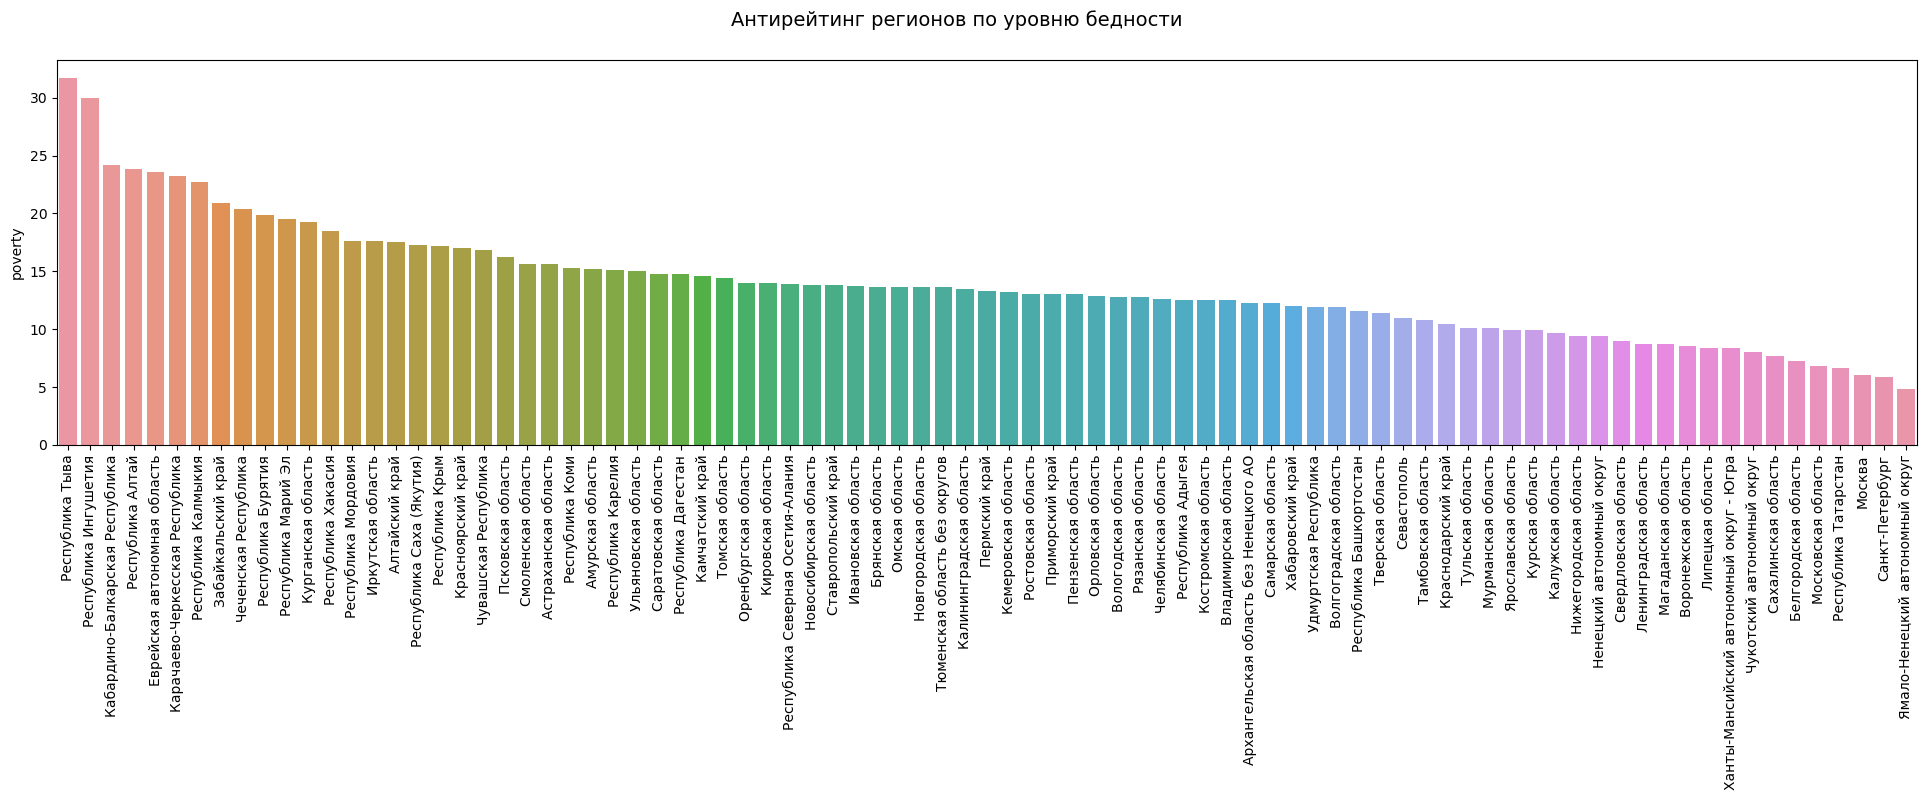

In [9]:
plot_df.sort_values(by='poverty', ascending=False, inplace=True)
fig = plt.figure(figsize=(24,5))
sns.barplot(data=plot_df, x=plot_df.index, y='poverty')
fig.suptitle(
    'Антирейтинг регионов по уровню бедности',
    fontsize=14);
plt.xlabel('')
plt.xticks(rotation = 90);

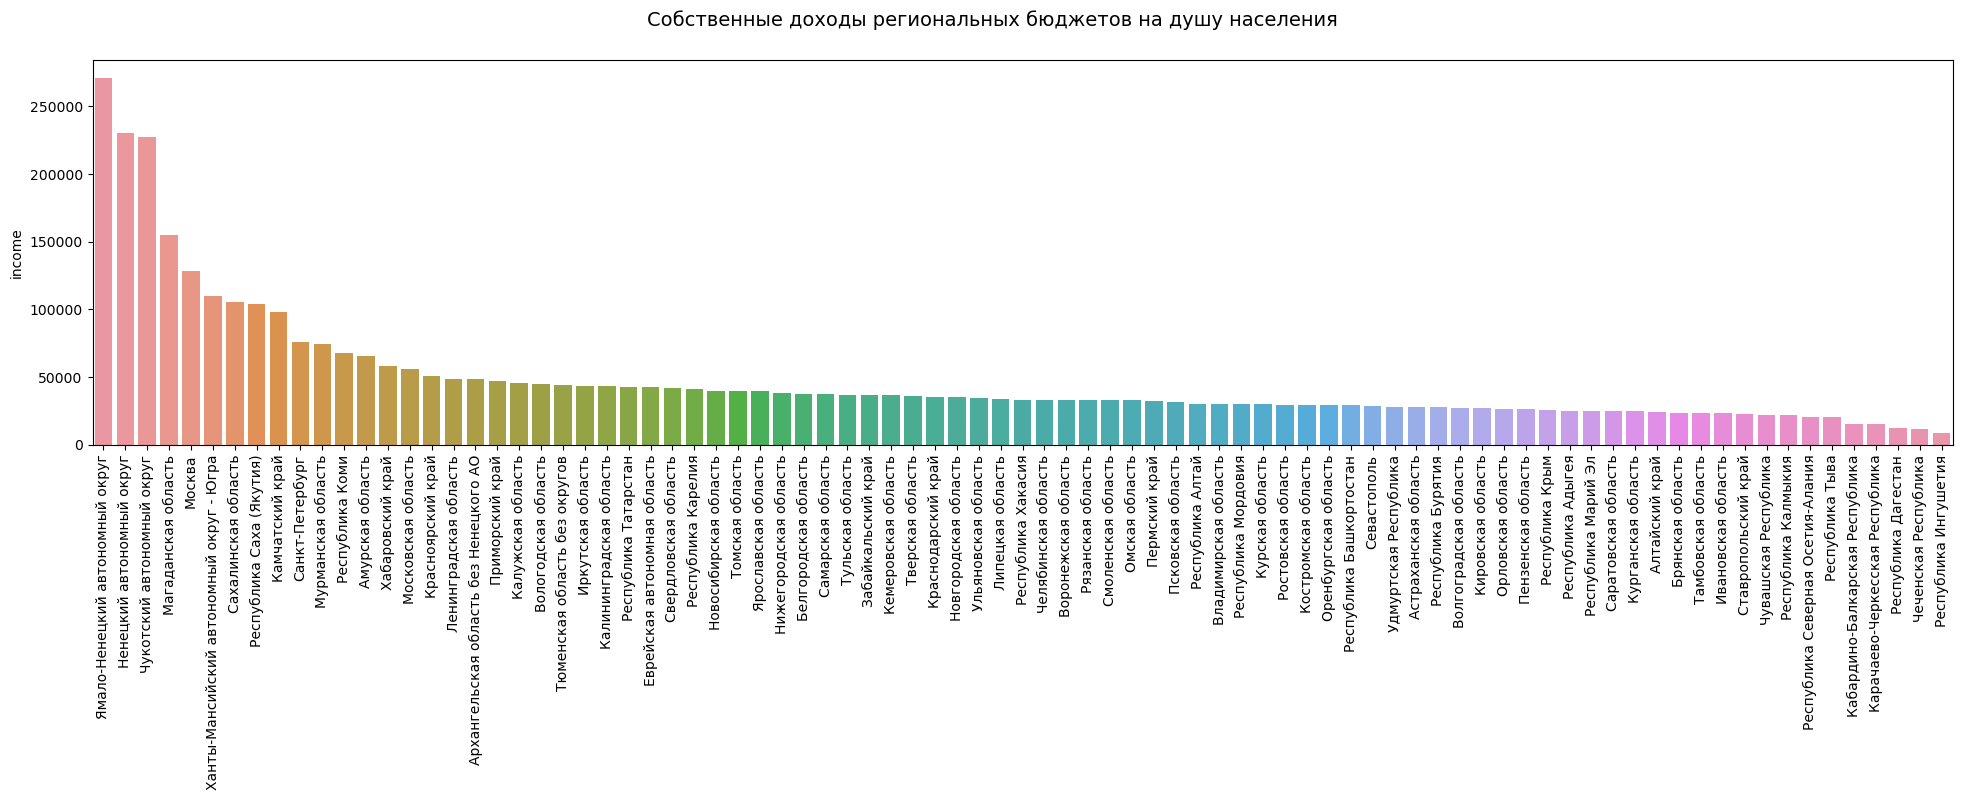

In [10]:
plot_df.sort_values(by='income', ascending=False, inplace=True)
fig = plt.figure(figsize=(24,5))
sns.barplot(data=plot_df, x=plot_df.index, y='income')
fig.suptitle(
    'Собственные доходы региональных бюджетов на душу населения',
    fontsize=14);
plt.xlabel('')
plt.xticks(rotation = 90);

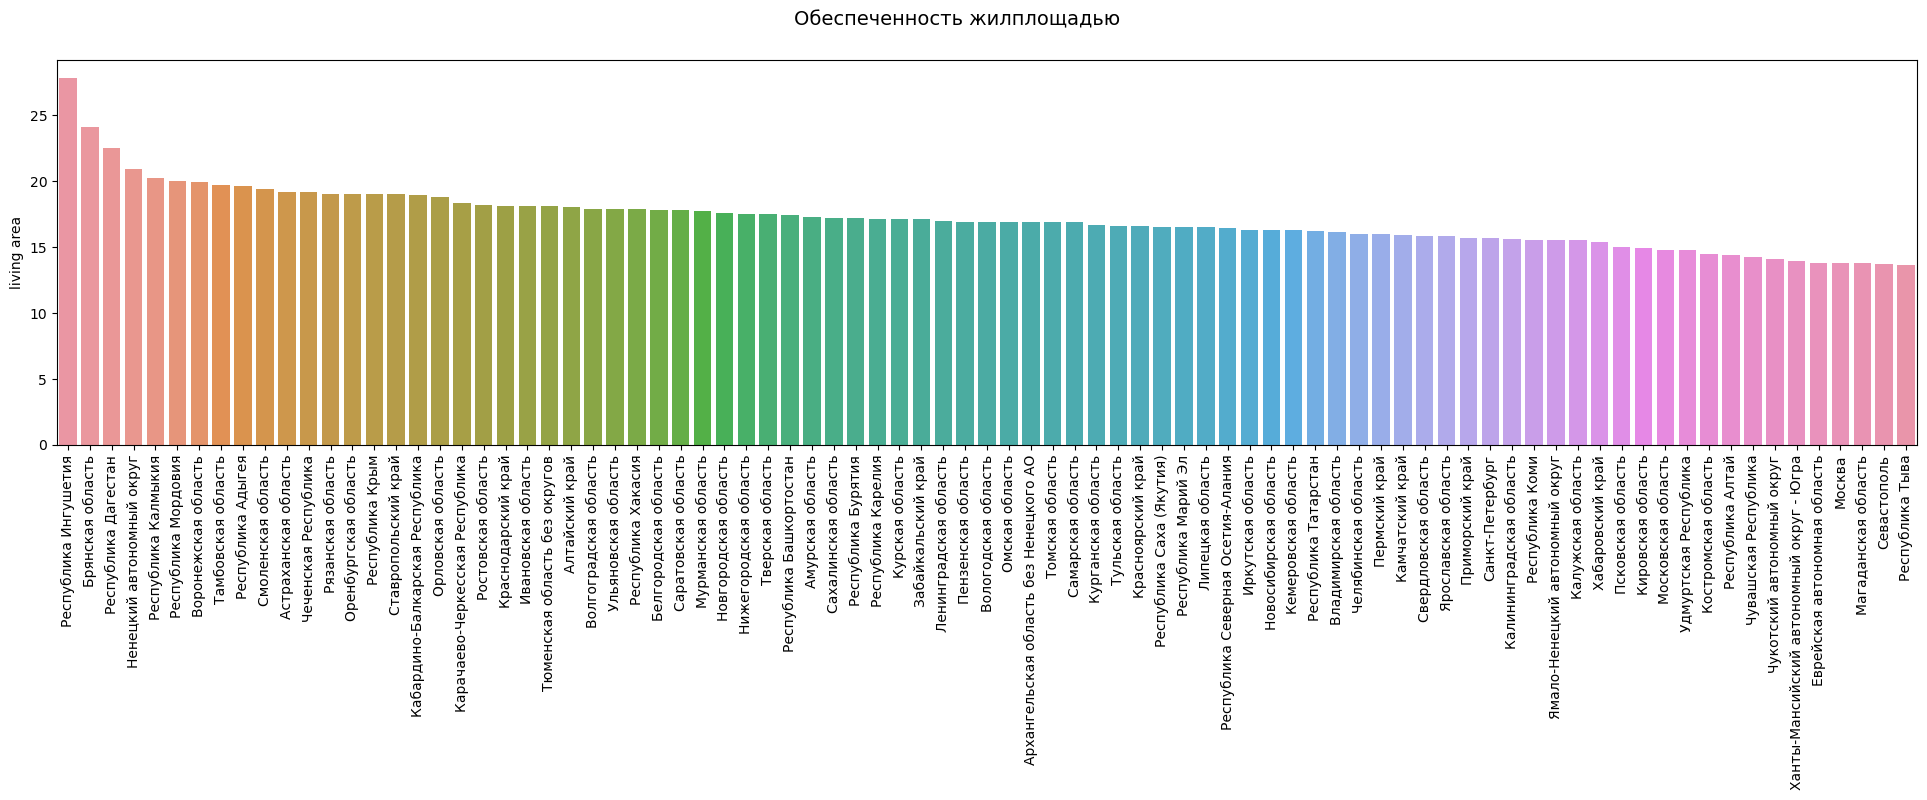

In [11]:
plot_df.sort_values(by='living area', ascending=False, inplace=True)
fig = plt.figure(figsize=(24,5))
sns.barplot(data=plot_df, x=plot_df.index, y='living area')
fig.suptitle(
    'Обеспеченность жилплощадью',
    fontsize=14);
plt.xlabel('')
plt.xticks(rotation = 90);

##### 2.1.4. Распределения и преобразования признаков

In [12]:
model_df['per capita norm'] = model_df['per capita'] / model_df['living wage']
model_df['formal wage norm'] = model_df['formal wage'] / model_df['living wage']
model_df['retail norm'] = model_df['retail'] / model_df['living wage']

model_df.drop(columns=['per capita', 'formal wage', 'retail'], axis=1, inplace=True)

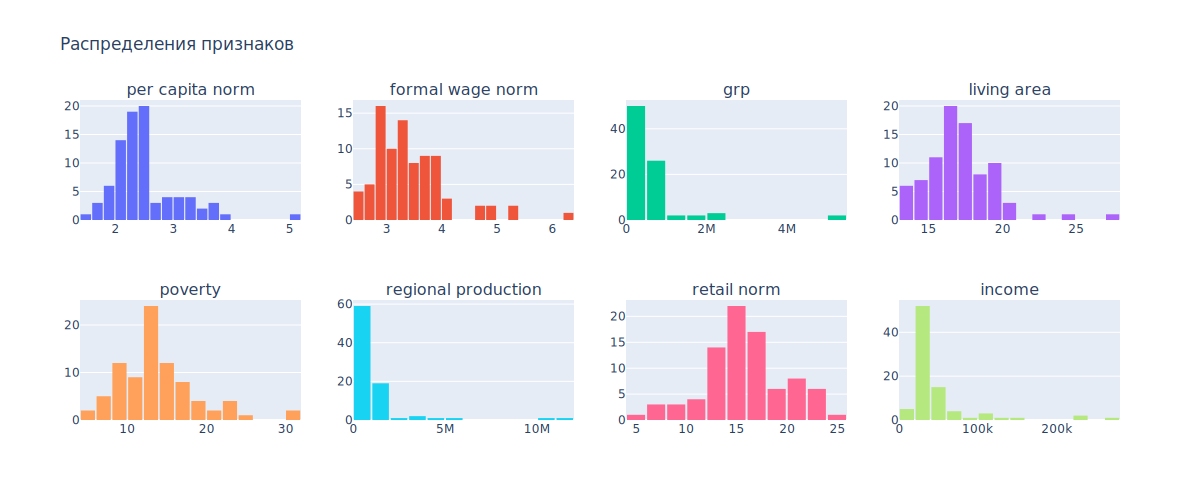

In [13]:
cols = ['per capita norm', 'formal wage norm', 'grp', 'living area', 
        'poverty', 'regional production', 'retail norm', 'income']
fig = make_subplots(rows=2, cols=4, subplot_titles=cols)
fig.add_trace(go.Histogram(x=model_df['per capita norm'], nbinsx=20),
              row=1, col=1)
fig.add_trace(go.Histogram(x=model_df['formal wage norm'], nbinsx=20),
              row=1, col=2)
fig.add_trace(go.Histogram(x=model_df['grp'], nbinsx=20),
              row=1, col=3)
fig.add_trace(go.Histogram(x=model_df['living area'], nbinsx=20),
              row=1, col=4)
fig.add_trace(go.Histogram(x=model_df['poverty'], nbinsx=20),
              row=2, col=1)
fig.add_trace(go.Histogram(x=model_df['regional production'], nbinsx=20),
              row=2, col=2)
fig.add_trace(go.Histogram(x=model_df['retail norm'], nbinsx=20),
              row=2, col=3)
fig.add_trace(go.Histogram(x=model_df['income'], nbinsx=20),
              row=2, col=4)
fig.update_layout(title='Распределения признаков', 
                  showlegend=False, width=1200, height=500)
fig.layout.bargap = 0.1
fig.show('svg')

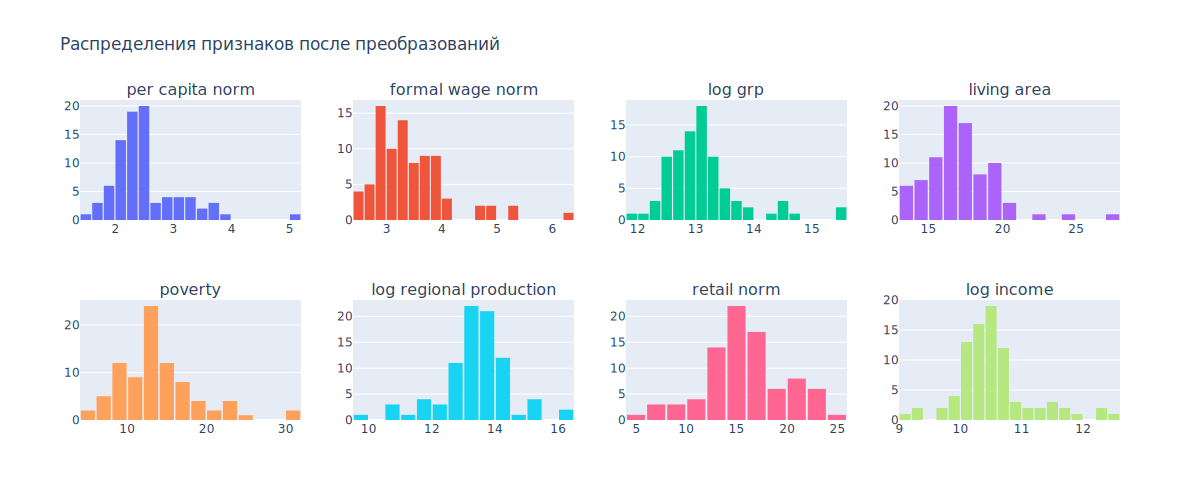

In [14]:
model_df['log grp'] = np.log(model_df['grp'])
model_df['log regional production'] = np.log(model_df['regional production'])
model_df['log income'] = np.log(model_df['income'])
model_df.drop(columns=['grp', 'regional production', 'income'], 
              axis=1, inplace=True)

cols = ['per capita norm', 'formal wage norm', 'log grp', 'living area', 
        'poverty', 'log regional production', 'retail norm', 'log income']
fig = make_subplots(rows=2, cols=4, subplot_titles=cols)
fig.add_trace(go.Histogram(x=model_df['per capita norm'], nbinsx=20),
              row=1, col=1)
fig.add_trace(go.Histogram(x=model_df['formal wage norm'], nbinsx=20),
              row=1, col=2)
fig.add_trace(go.Histogram(x=model_df['log grp'], nbinsx=20),
              row=1, col=3)
fig.add_trace(go.Histogram(x=model_df['living area'], nbinsx=20),
              row=1, col=4)
fig.add_trace(go.Histogram(x=model_df['poverty'], nbinsx=20),
              row=2, col=1)
fig.add_trace(go.Histogram(x=model_df['log regional production'], nbinsx=20),
              row=2, col=2)
fig.add_trace(go.Histogram(x=model_df['retail norm'], nbinsx=20),
              row=2, col=3)
fig.add_trace(go.Histogram(x=model_df['log income'], nbinsx=20),
              row=2, col=4)
fig.update_layout(title='Распределения признаков после преобразований', 
                  showlegend=False, width=1200, height=500)
fig.layout.bargap = 0.1
fig.show('svg')

In [15]:
cols = ['per capita norm', 'formal wage norm', 'log grp', 
        'log regional production', 'log income', 'retail norm', 
        'living area', 'poverty']
model_df = model_df[cols].copy()

In [16]:
for col in model_df.columns:
    _, p = shapiro(model_df[col])
    print(f'{col}:   p-value = {p:.3f}')

per capita norm:   p-value = 0.000
formal wage norm:   p-value = 0.000
log grp:   p-value = 0.000
log regional production:   p-value = 0.002
log income:   p-value = 0.000
retail norm:   p-value = 0.597
living area:   p-value = 0.000
poverty:   p-value = 0.000


##### 2.1.5. Корреляции, мультиколлинеарность

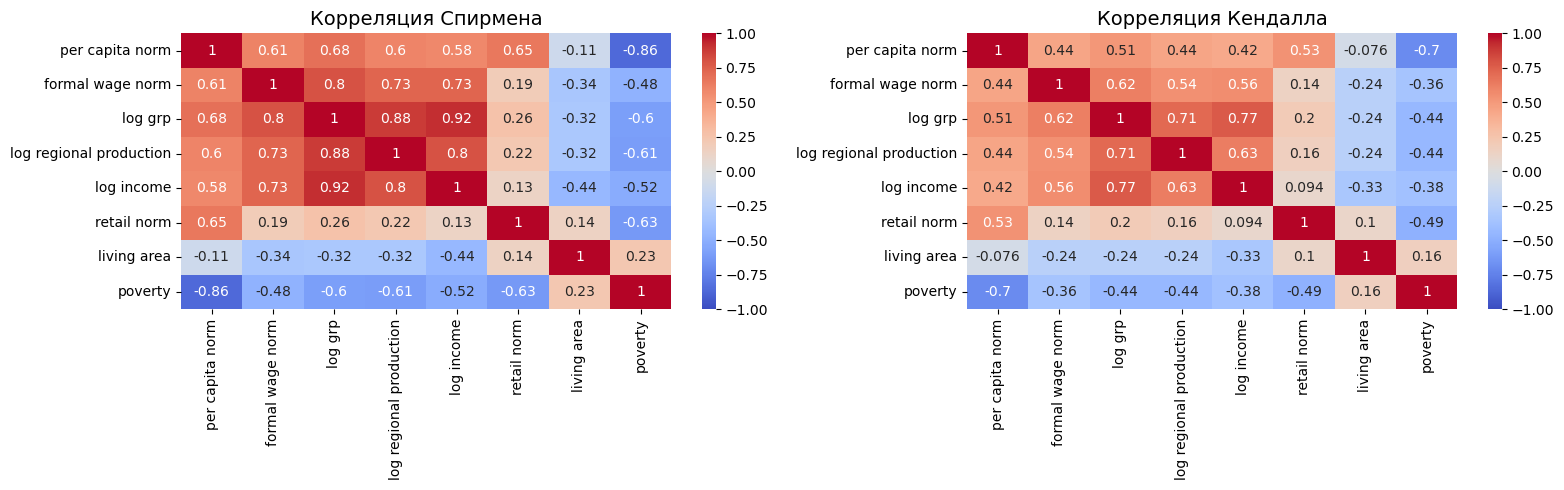

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.heatmap(model_df.corr(method='spearman'), 
            annot=True, cmap='coolwarm', vmin=-1, ax=ax[0])
sns.heatmap(model_df.corr(method='kendall'), 
            annot=True, cmap='coolwarm', vmin=-1, ax=ax[1])
ax[0].set_title('Корреляция Спирмена', fontsize=14)
ax[1].set_title('Корреляция Кендалла', fontsize=14)
plt.tight_layout();

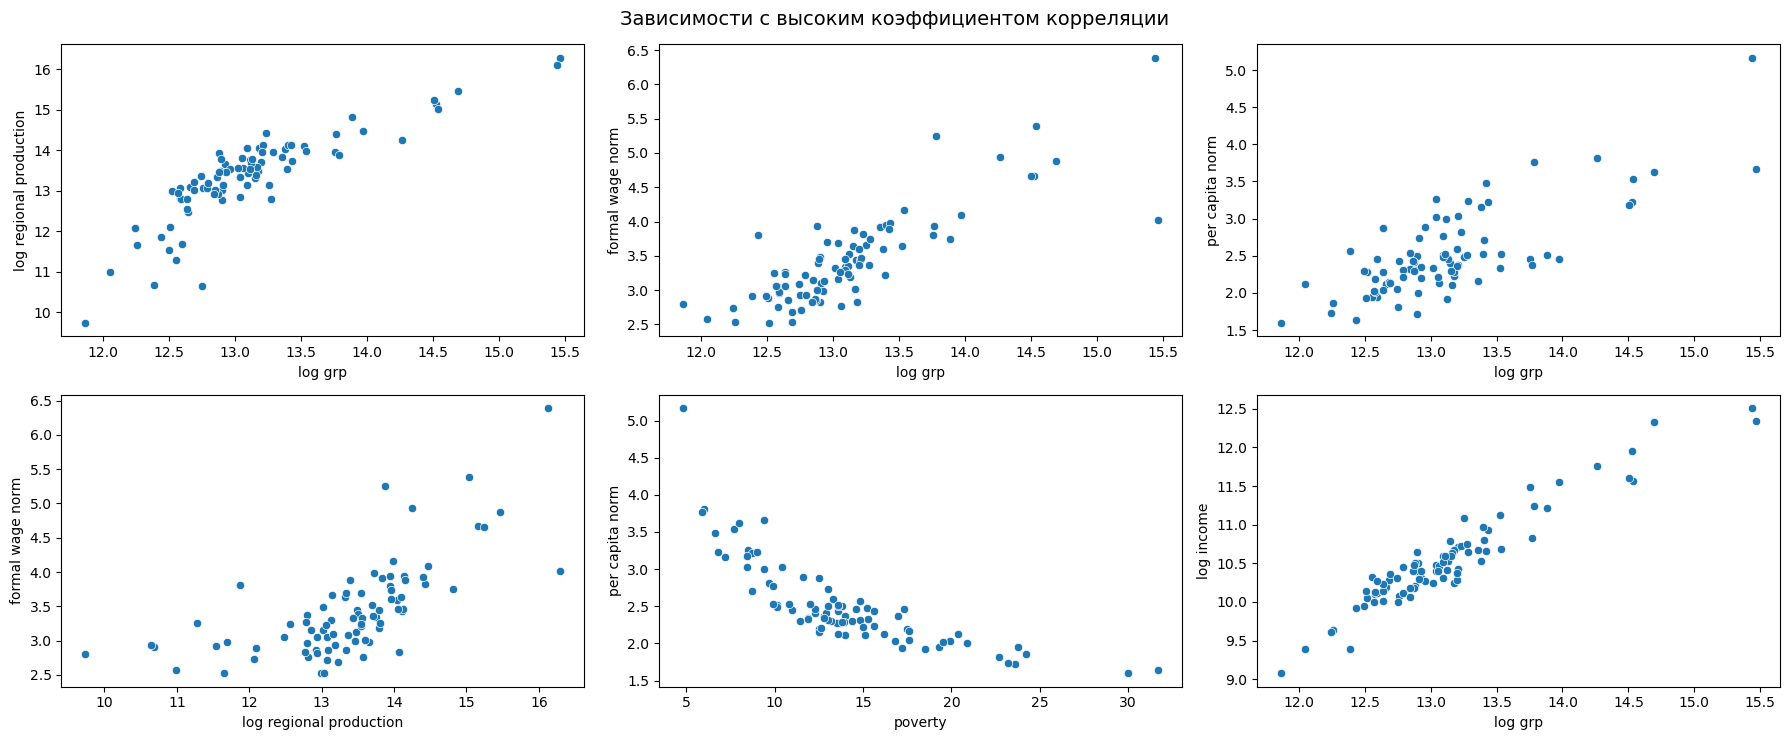

In [18]:
fig, ax = plt.subplots(2, 3, figsize=(18, 7.5))
sns.scatterplot(
    data=model_df, x= 'log grp', y ='log regional production', ax=ax[0, 0])
sns.scatterplot(
    data=model_df, x= 'log grp', y ='formal wage norm', ax=ax[0, 1])
sns.scatterplot(
    data=model_df, x= 'log grp', y ='per capita norm', ax=ax[0, 2])
sns.scatterplot(
    data=model_df, x= 'log regional production', y ='formal wage norm', ax=ax[1, 0])
sns.scatterplot(
    data=model_df, x= 'poverty', y ='per capita norm', ax=ax[1, 1])
sns.scatterplot(
    data=model_df, x= 'log grp', y ='log income', ax=ax[1, 2])
plt.suptitle('Зависимости с высоким коэффициентом корреляции', fontsize=14)
plt.tight_layout();

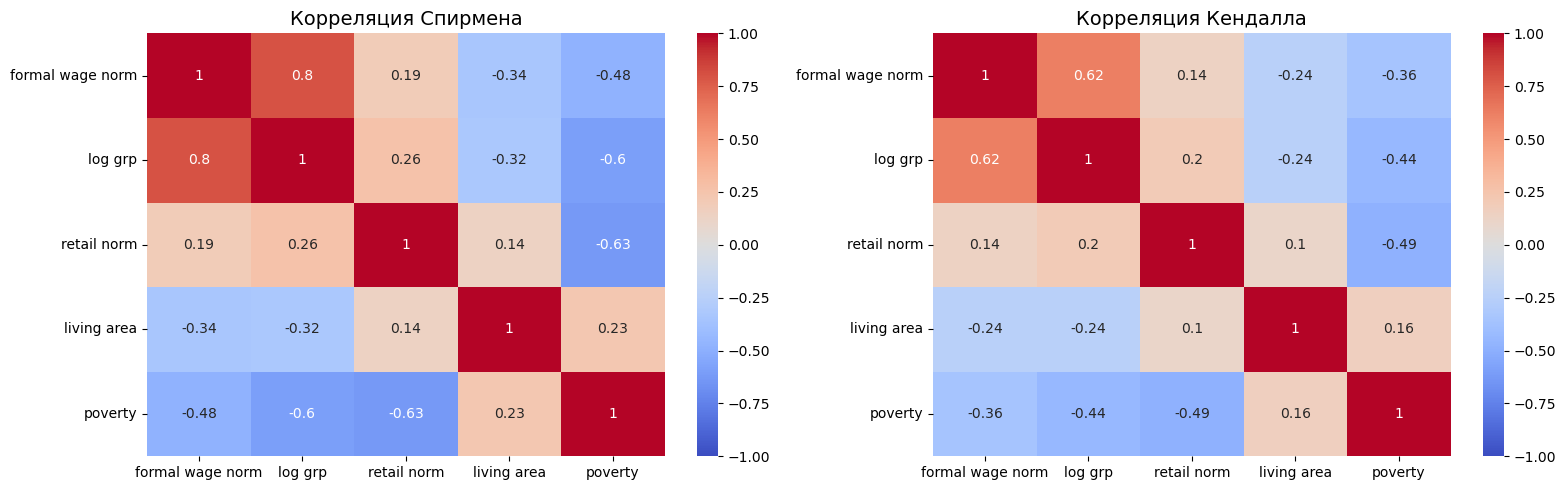

In [19]:
model_df.drop(
    columns=['log regional production', 'per capita norm', 'log income'], 
    axis=1, inplace=True)

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.heatmap(model_df.corr(method='spearman'), 
            annot=True, cmap='coolwarm', vmin=-1, ax=ax[0])
sns.heatmap(model_df.corr(method='kendall'), 
            annot=True, cmap='coolwarm', vmin=-1, ax=ax[1])
ax[0].set_title('Корреляция Спирмена', fontsize=14)
ax[1].set_title('Корреляция Кендалла', fontsize=14)
plt.tight_layout();

##### 2.1.6. Масштабирование

In [20]:
scaler = MinMaxScaler()
X = scaler.fit_transform(model_df)

### 2.2. Кластеризация

##### 2.2.1. Базовая модель: k-means

C:\Users\Apost\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Apost\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Apost\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Apost\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

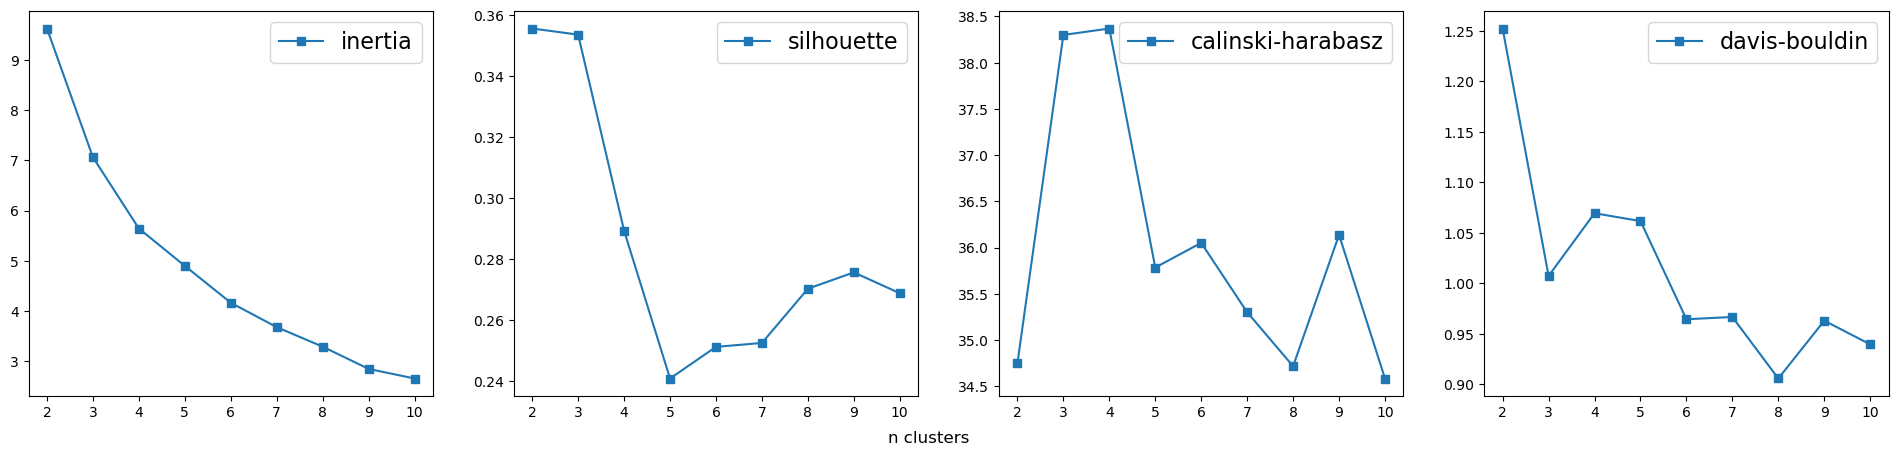

In [21]:
def plot_metrics(X):
    """Plot clustering metrics depending on the number of clusters"""
    inertia = []
    silhouette = []
    calinski_harabasz = []
    davis_bouldin = []
    
    for n_cl in range(2, 11):
        kmeans = cluster.KMeans(n_clusters=n_cl, random_state=42)
        kmeans.fit(X)
    
        inertia.append(kmeans.inertia_)
        silhouette.append(metrics.silhouette_score(
            X, kmeans.labels_))
        calinski_harabasz.append(metrics.calinski_harabasz_score(
            X, kmeans.labels_))
        davis_bouldin.append(metrics.davies_bouldin_score(
            X, kmeans.labels_))
        
    fig, ax = plt.subplots(1, 4, figsize=(24,5))
    
    ax[0].plot(range(2, 11), inertia, 's-', label='inertia')
    ax[1].plot(range(2, 11), silhouette, 's-', label='silhouette')
    ax[2].plot(range(2, 11), calinski_harabasz, 's-', label='calinski-harabasz')
    ax[3].plot(range(2, 11), davis_bouldin, 's-', label='davis-bouldin')
    ax[0].legend(prop={'size': 16})
    ax[1].legend(prop={'size': 16})
    ax[2].legend(prop={'size': 16})
    ax[3].legend(prop={'size': 16});
    fig.supxlabel('n clusters')
    
        
plot_metrics(X)

C:\Users\Apost\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Silhouette: 0.289
Calinski-Harabatz: 38.369
Davis-Bouldin: 1.069


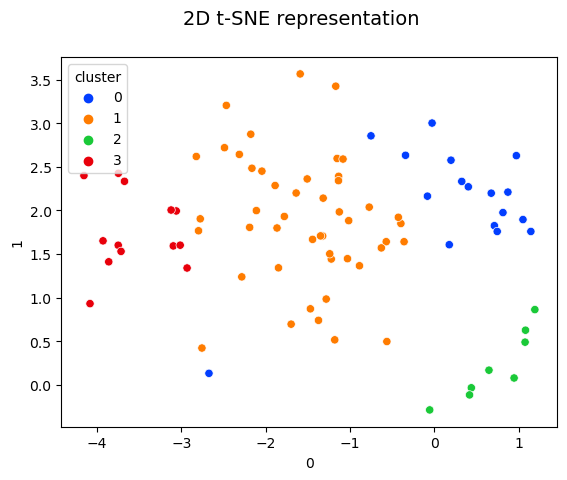

In [22]:
def plot_results(X, labels):
    "Plotting a 2D t-SNE representation and calculated metrics"
    tsne = TSNE(n_components=2, perplexity=50, init='pca',
                learning_rate='auto', random_state=42)
    df_tsne = pd.DataFrame(tsne.fit_transform(X))
    df_tsne['cluster'] = labels
    fig = plt.figure()
    sns.scatterplot(x=df_tsne[0], y=df_tsne[1],
                    hue=df_tsne['cluster'], palette='bright')
    fig.suptitle('2D t-SNE representation', fontsize=14);

    print('Silhouette: {:.3f}'.format(
        metrics.silhouette_score(X, labels)))
    print('Calinski-Harabatz: {:.3f}'.format(
        metrics.calinski_harabasz_score(X, labels)))
    print('Davis-Bouldin: {:.3f}'.format(
        metrics.davies_bouldin_score(X, labels)))
        

kmeans = cluster.KMeans(n_clusters=4, random_state=42)
bm_labels = kmeans.fit_predict(X)
plot_results(X, bm_labels)

##### 2.2.2. Понижение размерности. PCA + k-means

Число главных компонент: 3


C:\Users\Apost\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Apost\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Apost\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Apost\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

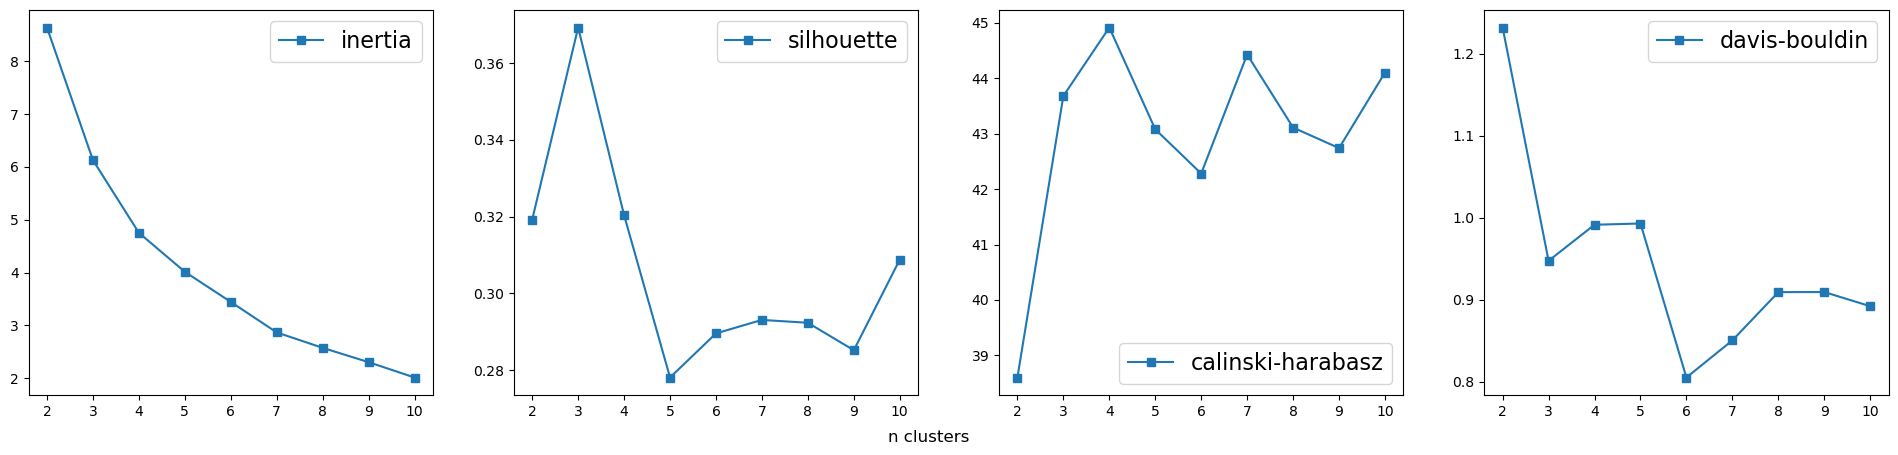

In [23]:
pca = PCA(n_components=0.9)  # 90% of explained dispersion
X_pca = pca.fit_transform(X)
print(f'Число главных компонент: {pca.n_components_}')

plot_metrics(X_pca)

C:\Users\Apost\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Silhouette: 0.320
Calinski-Harabatz: 44.917
Davis-Bouldin: 0.991
Rand score (сравнение с базовой моделью): 0.983473


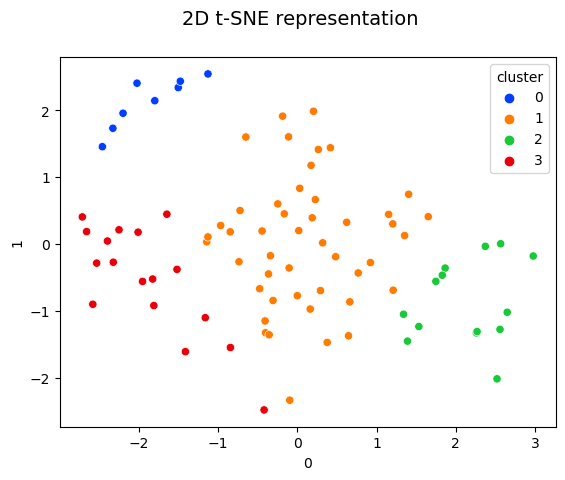

In [24]:
kmeans_pca = cluster.KMeans(n_clusters=4, random_state=42)
kmeans_pca.fit_predict(X_pca)
plot_results(X_pca, kmeans_pca.labels_)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(bm_labels, kmeans_pca.labels_)))

In [25]:
fig = px.scatter_3d(
    x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2],
    title='Кластеры в пространстве трех главных компонент (PCA)',
    color=kmeans_pca.labels_, width=650, height=400)
fig.update_traces(marker={'size':3}, marker_line_width=0.5)
#fig.show()
fig.write_image('C://Users//Apost//OneDrive//Рабочий стол//social_russia_data//kmeans_pca.png')

##### 2.2.3. Тестирование различных алгоритмов кластеризации, валидация

C:\Users\Apost\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Silhouette: 0.288
Calinski-Harabatz: 34.924
Davis-Bouldin: 0.909
Rand score (сравнение с базовой моделью): 0.660504


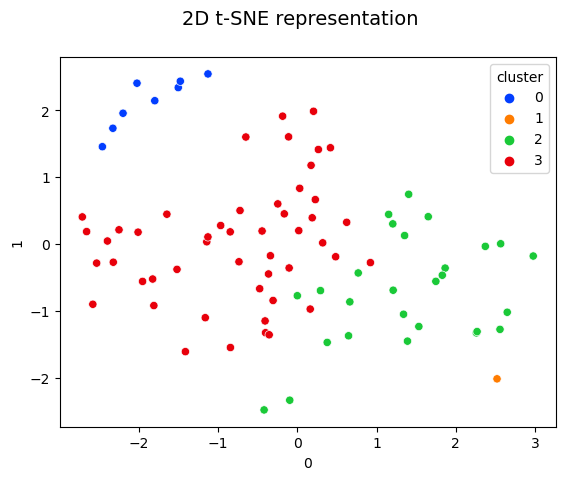

In [26]:
# Гауссова смесь, наилучший вариант: covariance_type='tied'
gmix = GaussianMixture(
    n_components=4, random_state=42, covariance_type='tied')
labels = gmix.fit_predict(X_pca)
plot_results(X_pca, labels)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(bm_labels, labels)))

Silhouette: 0.301
Calinski-Harabatz: 42.464
Davis-Bouldin: 0.971
Rand score (сравнение с базовой моделью): 0.873669


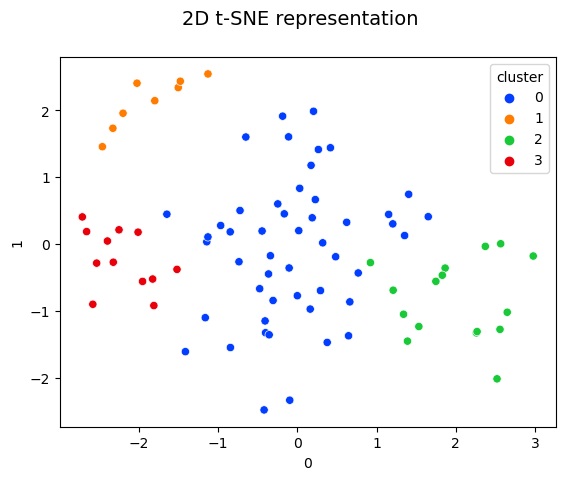

In [27]:
# Агломеративная кластеризация, наилучший вариант: linkage='ward'
tree_like = cluster.AgglomerativeClustering(n_clusters=4, linkage='ward')
labels = tree_like.fit_predict(X_pca)
plot_results(X_pca, labels)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(bm_labels, labels)))

Silhouette: 0.398
Calinski-Harabatz: 41.350
Davis-Bouldin: 0.906
Rand score (сравнение с базовой моделью): 0.734174


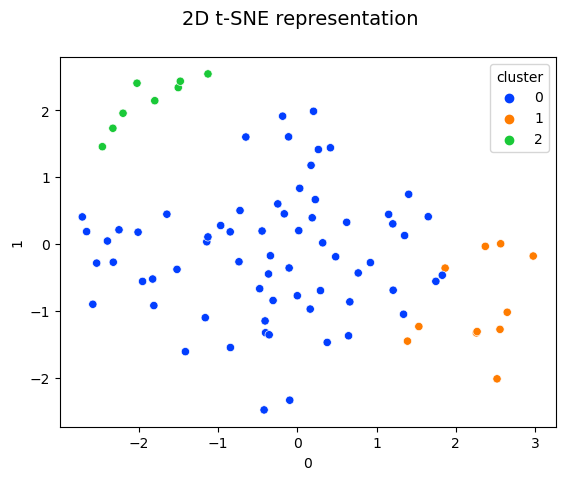

In [28]:
# Распространение сходства
aff_prop = cluster.AffinityPropagation(damping=0.9, random_state=42)
labels = aff_prop.fit_predict(X_pca)
plot_results(X_pca, labels)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(bm_labels, labels)))

C:\Users\Apost\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Silhouette: 0.263
Calinski-Harabatz: 39.150
Davis-Bouldin: 1.084
Rand score (сравнение с базовой моделью): 0.683473


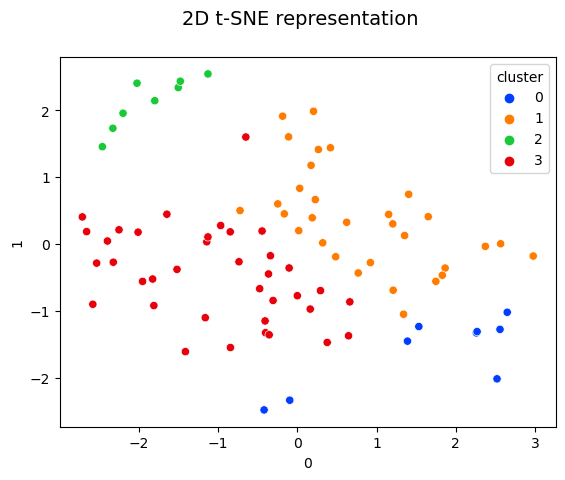

In [29]:
spectral = cluster.SpectralClustering(n_clusters=4)
labels = spectral.fit_predict(X_pca)
plot_results(X_pca, labels)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(bm_labels, labels)))

##### Выводы по результатам тестирования и валидации

In [30]:
# Гауссова смесь, наилучший вариант: covariance_type='tied'
gmix = GaussianMixture(
    n_components=4, random_state=42, covariance_type='tied')
labels_gmix = gmix.fit_predict(X_pca)
df['cluster'] = labels_gmix

# Упорядочим нумерацию кластеров 
df['cluster'] = df['cluster'].replace({2:0, 0:1, 3:2, 1:3})
df.to_csv('C://Users//Apost//OneDrive//Рабочий стол//social_russia_data//russia_regions_2020_clusters.csv')
df['cluster'].to_csv('C://Users//Apost//OneDrive//Рабочий стол//social_russia_data//labels.csv')

fig = px.scatter_3d(
    x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2],
    title='Кластеры в пространстве трех главных компонент (PCA)',
    color=df['cluster'], width=650, height=400)
fig.update_traces(marker={'size':3}, marker_line_width=0.5)
#fig.show()
fig.write_image('C://Users//Apost//OneDrive//Рабочий стол//social_russia_data//gmix_pca.png')

C:\Users\Apost\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [31]:
df

,per capita,formal wage,child mortality,disabled 18_60,alco (2018),drug (2018),grp,living area,bad conditions,no funds,...,misdemeanors,killed,grievous harm,children %,orphanage,adopted %,pension,retired %,living wage,cluster
region,,,,,,,,,,,,,,,,,,,,,
Алтайский край,23864.0,30072.0,0.485583,5.093525,88.1,17.4,291156.9,18.0,0.3,0.8642,...,8887,411,647,21.153070,983,59.0,16128.19,26.8,10904.0,0
Амурская область,35499.0,52430.0,0.534827,5.766846,113.3,24.4,571362.1,17.3,1.3,1.0731,...,4967,223,255,22.619247,676,65.0,17998.70,22.4,14331.0,2
Архангельская область без Ненецкого АО,34852.0,52779.0,0.325623,4.674270,64.7,9.2,514200.4,16.9,1.4,1.2998,...,4569,166,288,20.708809,785,60.0,21753.88,26.4,14507.0,2
Астраханская область,25199.0,38885.0,0.586564,3.632293,22.2,0.2,526950.9,19.2,0.8,2.9028,...,2818,93,169,22.620409,376,66.0,15427.85,23.9,11287.0,2
Белгородская область,32841.0,37442.0,0.380505,7.250936,41.3,3.2,646569.0,17.8,0.7,0.3840,...,3208,159,249,18.764730,219,82.0,17438.93,27.2,10403.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Чеченская Республика,24596.0,29771.0,0.601109,17.854091,4.1,0.6,171029.5,19.2,0.6,0.5539,...,717,24,21,37.089495,0,100.0,16165.00,10.3,11572.0,0
Чувашская Республика,21155.0,31844.0,0.212258,4.385201,79.0,1.2,287210.3,14.2,1.2,1.8768,...,3418,141,188,21.259663,161,77.0,16111.97,24.9,10414.0,0
Чукотский автономный округ,89541.0,120641.0,1.489758,3.515586,208.7,0.0,2404271.2,14.1,1.9,0.0000,...,167,28,20,25.099427,60,69.0,30144.56,14.5,24711.0,1


##### Вывод